# Aim

The primary aim is to develop deep learning models that accurately classify brain tumours in MRI scans, utilising advanced CNN architectures to enhance diagnostic speed and precision in clinical settings.

# Importing all libraries

In [137]:
import os
import zipfile
import shutil
import time
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, confusion_matrix as cm, classification_report as cr
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten, BatchNormalization, Conv2D, MaxPooling2D, Input
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint
from tensorflow.keras.applications import EfficientNetB1, VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras_tuner import HyperModel
from keras_tuner.tuners import RandomSearch

# Import and split dataset 

In [6]:
# Path to your local zip file
zip_file_path = r'C:\Users\lekha\[2]FYP\dataset.zip'  # Change this to your actual zip file path
extracted_folder_path = r'C:\Users\lekha\[2]FYP\dataset'    # Folder where the dataset will be extracted

# Extract the zip file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_folder_path)

# Define the labels (subfolders)
labels = ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']

# Directories for storing split data
train_dir = os.path.join(extracted_folder_path, 'train')
test_dir = os.path.join(extracted_folder_path, 'test')

# Create directories if they don't exist
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Split data into training and testing sets
train_test_split_ratio = 0.2  # 20% of data for testing

# Initialize dictionaries to store counts
num_images_per_label = {}
num_testing_images = {}

for label in labels:
    # Path to each tumor category
    label_dir = os.path.join(extracted_folder_path, label)
    images = os.listdir(label_dir)
    
    # Split images into training and testing
    train_images, test_images = train_test_split(images, test_size=train_test_split_ratio, random_state=42)
    
    # Create label subdirectories in train and test folders
    train_label_dir = os.path.join(train_dir, label)
    test_label_dir = os.path.join(test_dir, label)
    
    os.makedirs(train_label_dir, exist_ok=True)
    os.makedirs(test_label_dir, exist_ok=True)
    
    # Move the images to respective directories
    for image in train_images:
        shutil.move(os.path.join(label_dir, image), os.path.join(train_label_dir, image))
    
    for image in test_images:
        shutil.move(os.path.join(label_dir, image), os.path.join(test_label_dir, image))
    
    # Store the number of images in train and test sets for each label
    num_images_per_label[label] = len(train_images)
    num_testing_images[label] = len(test_images)
    
    print(f'Split completed for {label}: {len(train_images)} training and {len(test_images)} testing images')

print("Dataset splitting completed.")

Split completed for glioma_tumor: 660 training and 166 testing images
Split completed for meningioma_tumor: 657 training and 165 testing images
Split completed for no_tumor: 316 training and 79 testing images
Split completed for pituitary_tumor: 661 training and 166 testing images
Dataset splitting completed.


# Data Analysis & Visualisation

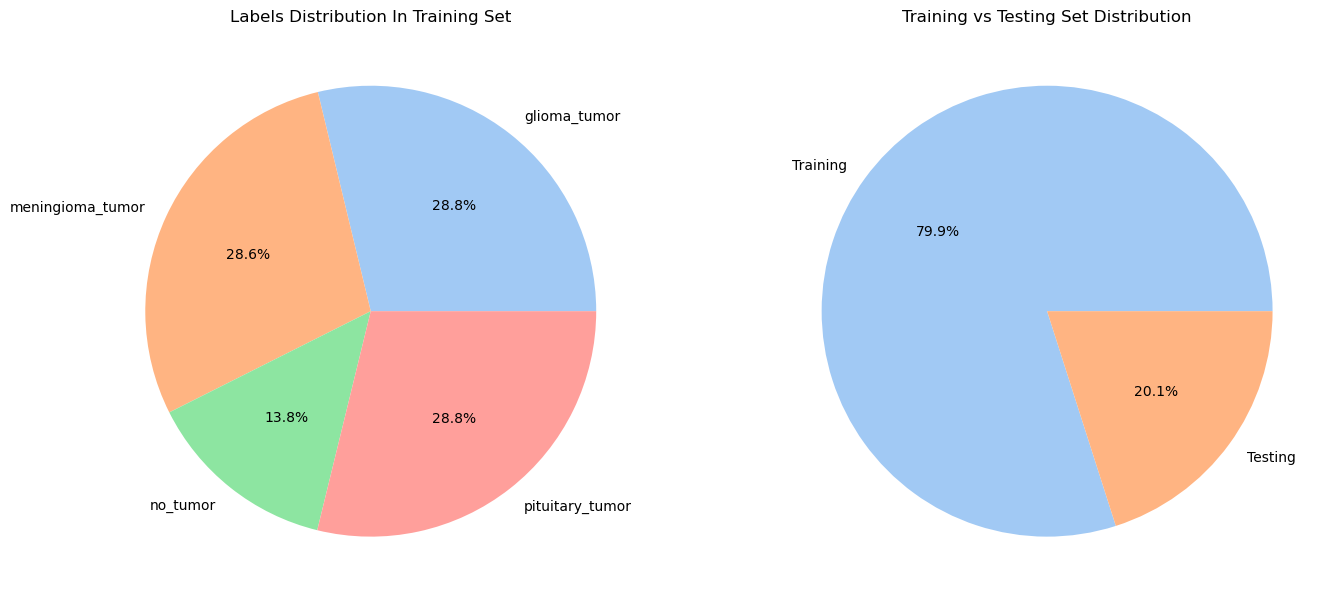

In [8]:
# Visualize class distribution in train set
plt.figure(figsize=(16, 8))
colors = sns.color_palette('pastel')

# Pie chart for label distribution in training set
plt.subplot(1, 2, 1)
plt.pie(num_images_per_label.values(), labels=num_images_per_label.keys(), autopct='%1.1f%%', colors=colors)
plt.title('Labels Distribution In Training Set')

# Pie chart for overall training vs testing distribution
plt.subplot(1, 2, 2)
plt.pie([sum(num_images_per_label.values()), sum(num_testing_images.values())], labels=['Training', 'Testing'], autopct='%1.1f%%', colors=colors)
plt.title('Training vs Testing Set Distribution')

plt.show()

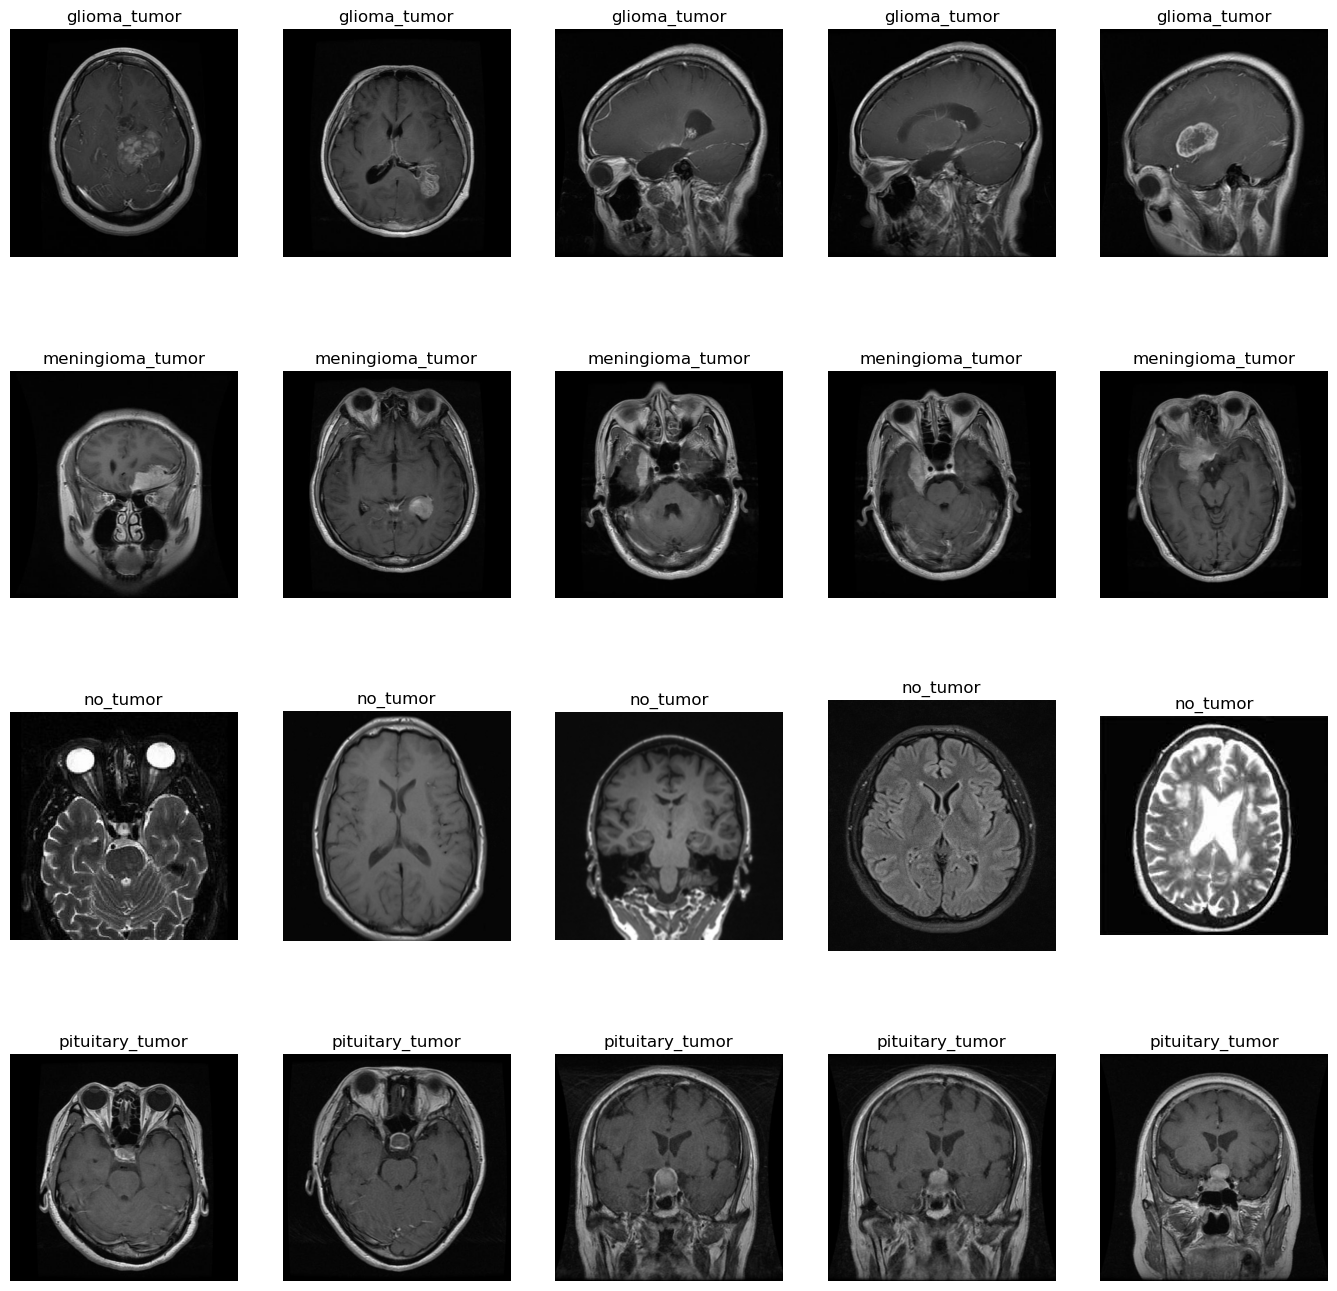

In [9]:
# Supported image extensions
valid_image_extensions = ['.jpg', '.jpeg', '.png', '.bmp']  # Add other formats if needed

# Initialize a dictionary to store file paths for each label
files_path_dict = {}

# Populate the dictionary with image paths after splitting, filtering for valid images only
for label in labels:
    # Get the paths for images in the training set
    train_label_dir = os.path.join(train_dir, label)
    image_paths = [
        os.path.join(train_label_dir, img) 
        for img in os.listdir(train_label_dir) 
        if os.path.splitext(img)[1].lower() in valid_image_extensions  # Filter for valid image extensions
    ]
    
    # Store in dictionary
    files_path_dict[label] = image_paths

# Visualize a few sample images from each class
plt.figure(figsize=(17, 17))
index = 0
for label in labels:
    path_list = files_path_dict[label][:5]  # Show first 5 images from each label
    for i in range(5):  # Adjust loop to correctly display 5 images per class
        index += 1
        plt.subplot(4, 5, index)  # Adjust to 4x5 grid (for 20 images)
        
        img_path = path_list[i]
        img = cv2.imread(img_path)
        
        # Check if the image was loaded successfully
        if img is None:
            print(f"Image at {img_path} could not be loaded.")
            continue
        
        # Convert BGR to RGB for displaying
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.imshow(img_rgb)
        plt.title(label)
        plt.axis('off')  # Turn off axis

plt.show()

# Data Preprocessing

## Crop images

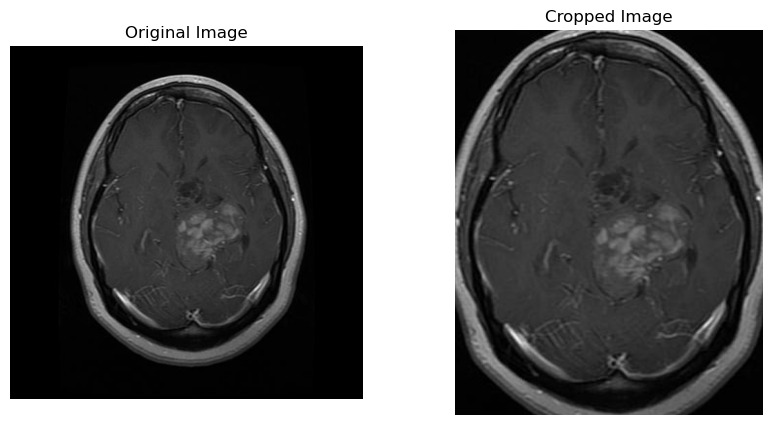

In [12]:
# Function to extract contour and crop the image
def extract_contour(image):
    # Convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Apply GaussianBlur to reduce noise and improve contour detection
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    
    # Use Canny edge detection
    edged = cv2.Canny(blurred, 30, 150)
    
    # Find contours in the edged image
    contours, _ = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Ensure at least one contour was found
    if len(contours) == 0:
        return image
    
    # Find the largest contour
    c = max(contours, key=cv2.contourArea)
    
    # Get the bounding box for the largest contour
    x, y, w, h = cv2.boundingRect(c)
    
    # Crop the image using the bounding box coordinates
    cropped = image[y:y+h, x:x+w]
    
    return cropped

# Corrected path to the sample image
sample_image_path = os.path.join(extracted_folder_path, 'train','glioma_tumor', 'gg (1).jpg')

# Verify that the file exists
if not os.path.exists(sample_image_path):
    print(f"Error: The file {sample_image_path} does not exist.")
else:
    # Load the sample image
    sample = cv2.imread(sample_image_path)
    
    # Check if the image was loaded successfully
    if sample is None:
        print("Error: The image could not be loaded. Please check the file path and format.")
    else:
        # Crop the sample image
        cropped_sample = extract_contour(sample)

        # Convert BGR to RGB for displaying with matplotlib
        cropped_sample_rgb = cv2.cvtColor(cropped_sample, cv2.COLOR_BGR2RGB)

        # Display the original and cropped image
        plt.figure(figsize=(10, 5))

        plt.subplot(1, 2, 1)
        plt.title('Original Image')
        plt.imshow(cv2.cvtColor(sample, cv2.COLOR_BGR2RGB))
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.title('Cropped Image')
        plt.imshow(cropped_sample_rgb)
        plt.axis('off')

        plt.show()


## Split training dataset

In [14]:
# Assuming files_path_dict contains the image paths for each class and the labels are stored in the 'labels' list.
X = []  # Image paths
y = []  # Labels (glioma_tumor, meningioma_tumor, no_tumor, pituitary_tumor)
IMG_SIZE = (256, 256)  # Resize images to 256x256 for consistency

# Load images and their corresponding labels
for label_index, label in enumerate(labels):
    for img_path in files_path_dict[label]:
        img = cv2.imread(img_path)  # Read the image
        img = cv2.resize(img, IMG_SIZE)  # Resize image to 256x256
        X.append(img)  # Append the image array to X
        y.append(label_index)  # Append the label index to y

# Convert X and y to numpy arrays for splitting
X = np.array(X)
y = np.array(y)

# Split the training data into training and validation sets (70% training, 30% validation)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Check the number of samples in each set
print(f"Number of training samples = {X_train.shape[0]}")
print(f"Number of validation samples = {X_val.shape[0]}")

# Since test set is separate and already available, load test images
X_test = []  # Image arrays for the test set
y_test = []  # Labels for the test set

# Populate test set from the test folder
for label_index, label in enumerate(labels):
    test_path = os.path.join(extracted_folder_path, 'test', label)
    test_images = [os.path.join(test_path, x) for x in os.listdir(test_path) if x.endswith(('.jpg', '.jpeg', '.png'))]
    
    for img_path in test_images:
        img = cv2.imread(img_path)  # Read the image
        img = cv2.resize(img, IMG_SIZE)  # Resize image to 256x256
        X_test.append(img)  # Append the image array to X_test
        y_test.append(label_index)  # Append the label index to y_test

# Convert test set to numpy arrays
X_test = np.array(X_test)
y_test = np.array(y_test)

# Check the number of test samples
print(f"Number of test samples = {X_test.shape[0]}")

Number of training samples = 1605
Number of validation samples = 689
Number of test samples = 576


## Data augmentation 

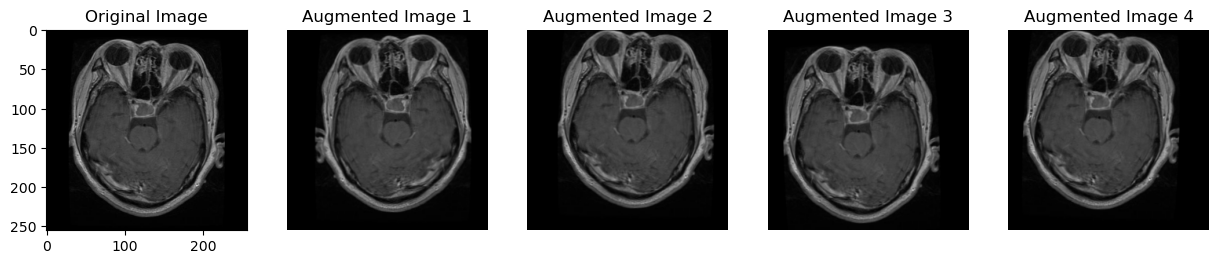

In [16]:
# Data augmentation setup using ImageDataGenerator
data_generator = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.05,
    height_shift_range=0.05,
    horizontal_flip=True,
    fill_mode='nearest'  # Handle missing pixels after transformation
)

# Reshape an example image to (1, height, width, channels) since X_train contains image arrays
img = X_train[0]  # Directly use the image array from X_train
img = np.reshape(img, (1,) + img.shape)  # Add batch dimension for ImageDataGenerator

# Generate augmented images
augmented_image = data_generator.flow(img)

# Plot the original and 4 augmented images
fig, axs = plt.subplots(1, 5, figsize=(15, 3))
axs[0].imshow(X_train[0].astype('int'))  # Display the original image
axs[0].set_title("Original Image")

# Iterate through the next 4 augmented images
for i in range(1, 5):
    augmented_img = next(augmented_image)[0].astype('int')  # Get the next augmented image
    axs[i].imshow(augmented_img)
    axs[i].set_title(f"Augmented Image {i}")
    axs[i].axis('off')  # Hide axis for better visualization

plt.show()


# Baseline CNN Model

## Model Definition

In [19]:
# Function to build the CNN model
def build_sequential_model(input_shape, num_classes):
    model = Sequential()
    model.add(Input(shape=input_shape))
    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))  # Output layer with softmax
    return model

## Set Model Parameters and Compile

In [21]:
# Parameters
IMG_SHAPE = (256, 256, 3)
num_classes = len(labels)  # Number of classes (e.g., 4 for tumor types)

# Build the model
baseline_model = build_sequential_model(IMG_SHAPE, num_classes)

# Print the model summary
baseline_model.summary()

# Compile the model
baseline_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 254, 254, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 127, 127, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 125, 125, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 62, 62, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 60, 60, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 30, 30, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 115200)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │      58,982,912 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │           2,052 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 59,078,212 (225.37 MB)

 Trainable params: 59,078,212 (225.37 MB)

 Non-trainable params: 0 (0.00 B)

## Model Checkpoint and TensorBoard Setup

In [23]:
# Define model path and create the directory if it doesn't exist
models_path = "models"  # Directory to save the model
if not os.path.exists(models_path):
    os.makedirs(models_path)

# TensorBoard and ModelCheckpoint setup
log_dir = "logs/fit/" + time.strftime("run_%Y%m%d-%H%M%S")
tensorboard = TensorBoard(log_dir=log_dir, histogram_freq=1)
checkpoint_filepath = f'{models_path}/best_model.keras'
checkpoint = ModelCheckpoint(filepath=checkpoint_filepath, save_best_only=True, monitor='val_loss', mode='min')

## Train the Model

In [25]:
start_time = time.time()
history = baseline_model.fit(
    x=X_train, 
    y=y_train, 
    batch_size=32, 
    epochs=10, 
    validation_data=(X_val, y_val), 
    callbacks=[tensorboard, checkpoint]
)
end_time = time.time()
execution_time = end_time - start_time

# Function to display the execution time
def hms_string(sec_elapsed):
    h = int(sec_elapsed // 3600)
    m = int((sec_elapsed % 3600) // 60)
    s = int(sec_elapsed % 60)
    return f"{h}h:{m}m:{s}s"

print(f"Elapsed time: {hms_string(execution_time)}")

Epoch 1/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 127s 2s/step - accuracy: 0.4424 - loss: 334.9713 - val_accuracy: 0.7054 - val_loss: 0.8216
Epoch 2/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 132s 3s/step - accuracy: 0.7250 - loss: 0.6832 - val_accuracy: 0.7591 - val_loss: 0.7137
Epoch 3/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 125s 2s/step - accuracy: 0.8645 - loss: 0.3736 - val_accuracy: 0.7605 - val_loss: 0.7019
Epoch 4/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 122s 2s/step - accuracy: 0.9277 - loss: 0.2228 - val_accuracy: 0.7779 - val_loss: 0.6933
Epoch 5/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 117s 2s/step - accuracy: 0.9392 - loss: 0.1878 - val_accuracy: 0.7910 - val_loss: 0.7852
Epoch 6/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 133s 3s/step - accuracy: 0.9540 - loss: 0.1307 - val_accuracy: 0.8041 - val_loss: 0.8478
Epoch 7/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 151s 3s/step - accuracy: 0.9912 - loss: 0.0422 - val_accuracy: 0.8215 - val_loss: 0.9101
Epoch 8/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 136s 3s/step - accuracy: 0.9906 - loss: 0.0398 - val_accuracy: 0.8360 -

## Plot Training/Validation Metrics

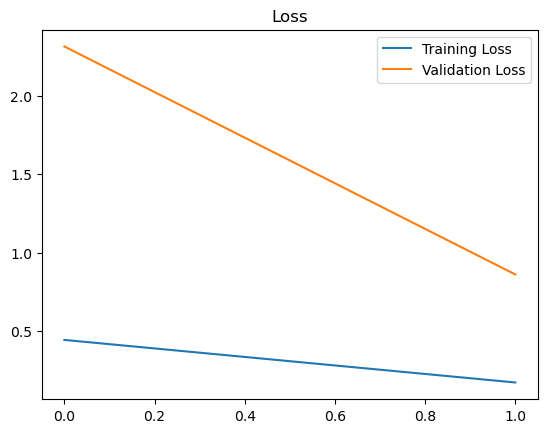

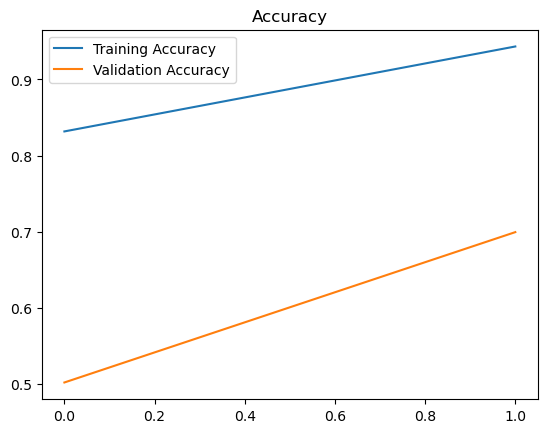

In [82]:
# Function to plot training/validation metrics
def plot_metrics(history):
    train_loss = history['loss']
    val_loss = history['val_loss']
    train_acc = history['accuracy']
    val_acc = history['val_accuracy']

    # Loss
    plt.figure()
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title('Loss')
    plt.legend()
    plt.show()

    # Accuracy
    plt.figure()
    plt.plot(train_acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.title('Accuracy')
    plt.legend()
    plt.show()

# Plot metrics based on training history
plot_metrics(history.history)

## Evaluate the Model

In [85]:
# Load the best model from the models directory
best_baseline_model = load_model(filepath=f'{models_path}/best_model.keras')

# Evaluate both the current and best models
print("Evaluating baseline model:")
baseline_model.evaluate(x=X_val, y=y_val)

print("\nEvaluating best baseline model:")
best_baseline_model.evaluate(x=X_val, y=y_val)

Evaluating baseline model:
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 146ms/step - accuracy: 0.7882 - loss: 1.2377

Evaluating best baseline model:
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 139ms/step - accuracy: 0.7684 - loss: 0.7191


[0.6933343410491943, 0.7779390215873718]

## Confusion Matrix and Classification Report

In [87]:
# Predict on validation data
y_val_pred = best_baseline_model.predict(X_val)
y_val_pred_arg = y_val_pred.argmax(axis=1)  # Get the index of the highest probability for each sample

# Confusion matrix
def confusion_matrix(data_set, predictions, labels):
    cmatrix = cm(data_set, predictions)
    fig, ax = plt.subplots(figsize=(8, 8))
    sns.heatmap(cmatrix, annot=True, cmap='Blues', fmt='g', ax=ax)
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix')
    ax.xaxis.set_ticklabels(labels)
    ax.yaxis.set_ticklabels(labels)
    plt.show()

# Classification report
def classification_report(data_set, predictions, labels):
    print('Classification Report')
    print(cr(data_set, predictions, target_names=labels))

22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 153ms/step



Confusion Matrix:


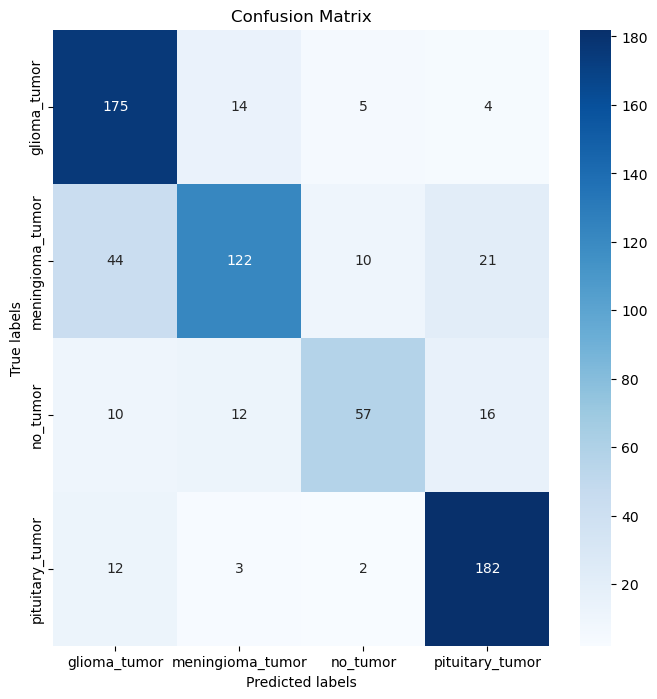

In [88]:
# Compute and print confusion matrix and classification report
print("\nConfusion Matrix:")
confusion_matrix(y_val, y_val_pred_arg, labels)

In [89]:
print("\nClassification Report:")
classification_report(y_val, y_val_pred_arg, labels)


Classification Report:
Classification Report
                  precision    recall  f1-score   support

    glioma_tumor       0.73      0.88      0.80       198
meningioma_tumor       0.81      0.62      0.70       197
        no_tumor       0.77      0.60      0.67        95
 pituitary_tumor       0.82      0.91      0.86       199

        accuracy                           0.78       689
       macro avg       0.78      0.75      0.76       689
    weighted avg       0.78      0.78      0.77       689



# VGG16

## Model Definition and Compilation

In [92]:
# Parameters
IMG_SHAPE = (256, 256, 3)  # Example image shape (width, height, channels)
num_classes = len(labels)  # Adjust the number of classes based on your dataset

# VGG16 with pretrained weights
vgg = VGG16(input_shape=IMG_SHAPE, weights='imagenet', include_top=False)

# Freeze the layers of VGG16
for layer in vgg.layers:
    layer.trainable = False

# Adding custom layers on top of VGG16
x = Flatten()(vgg.output)
x = Dense(units=512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(rate=0.5)(x)
x = Dense(units=num_classes, activation='softmax')(x)  # Adjust the number of units based on num_classes

# Define the final VGG16-based model
vgg16_model = Model(inputs=vgg.input, outputs=x)

# Compile the model
vgg16_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Print model summary
vgg16_model.summary()

Model: "functional_29"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 256, 256, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 256, 256, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 128, 128, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 128, 128, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 128, 128, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 64, 64, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 64, 64, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 64, 64, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 64, 64, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 32, 32, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 32, 32, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 32, 32, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 32, 32, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 16, 16, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 16, 16, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 16, 16, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 16, 16, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 8, 8, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 32768)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 512)                 │      16,777,728 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 31,496,516 (120.15 MB)

 Trainable params: 16,780,804 (64.01 MB)

 Non-trainable params: 14,715,712 (56.14 MB)

## TensorBoard and ModelCheckpoint Setup

In [94]:
import time
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint

# Define model path and create the directory if it doesn't exist
models_path = "models"  # Directory to save the model
if not os.path.exists(models_path):
    os.makedirs(models_path)

# TensorBoard and ModelCheckpoint setup
log_dir = "logs/fit/" + time.strftime("run_%Y%m%d-%H%M%S")
tensorboard = TensorBoard(log_dir=log_dir, histogram_freq=1)
checkpoint_filepath = f'{models_path}/best_vgg16_model.keras'
checkpoint = ModelCheckpoint(filepath=checkpoint_filepath, save_best_only=True, monitor='val_loss', mode='min')

## Training the VGG16 Model

In [96]:
start_time = time.time()
history = vgg16_model.fit(
    x=X_train, 
    y=y_train, 
    batch_size=32, 
    epochs=10, 
    validation_data=(X_val, y_val), 
    callbacks=[tensorboard, checkpoint]
)
end_time = time.time()
execution_time = end_time - start_time

# Function to display the execution time in hours, minutes, and seconds
def hms_string(sec_elapsed):
    h = int(sec_elapsed // 3600)
    m = int((sec_elapsed % 3600) // 60)
    s = int(sec_elapsed % 60)
    return f"{h}h:{m}m:{s}s"

print(f"Elapsed time: {hms_string(execution_time)}")

Epoch 1/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 322s 6s/step - accuracy: 0.7001 - loss: 1.1927 - val_accuracy: 0.8737 - val_loss: 0.5250
Epoch 2/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 346s 7s/step - accuracy: 0.9430 - loss: 0.1782 - val_accuracy: 0.8999 - val_loss: 0.3626
Epoch 3/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 346s 7s/step - accuracy: 0.9626 - loss: 0.1051 - val_accuracy: 0.9144 - val_loss: 0.3274
Epoch 4/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 344s 7s/step - accuracy: 0.9766 - loss: 0.0671 - val_accuracy: 0.9129 - val_loss: 0.3028
Epoch 5/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 344s 7s/step - accuracy: 0.9899 - loss: 0.0398 - val_accuracy: 0.9100 - val_loss: 0.3152
Epoch 6/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 344s 7s/step - accuracy: 0.9876 - loss: 0.0312 - val_accuracy: 0.9115 - val_loss: 0.2992
Epoch 7/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 344s 7s/step - accuracy: 0.9849 - loss: 0.0527 - val_accuracy: 0.9071 - val_loss: 0.3318
Epoch 8/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 343s 7s/step - accuracy: 0.9905 - loss: 0.0292 - val_accuracy: 0.9158 - v

## Plot Training/Validation Metrics

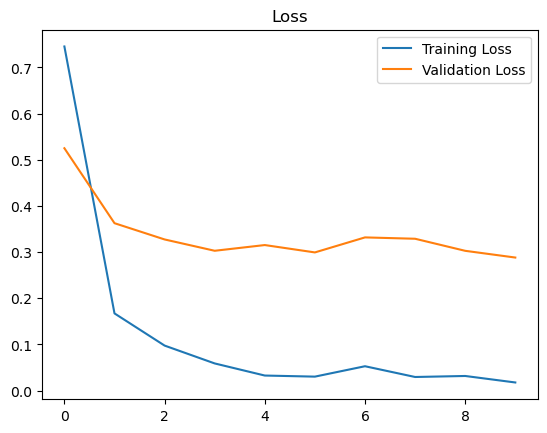

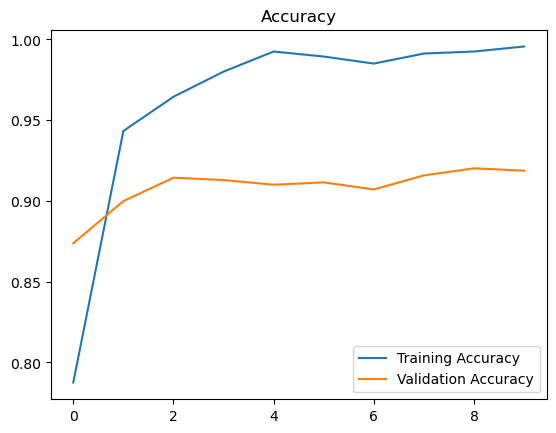

In [98]:
import matplotlib.pyplot as plt

# Function to plot training/validation metrics
def plot_metrics(history):
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    train_acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    # Loss
    plt.figure()
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title('Loss')
    plt.legend()
    plt.show()

    # Accuracy
    plt.figure()
    plt.plot(train_acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.title('Accuracy')
    plt.legend()
    plt.show()

# Use the corrected plot_metrics function
plot_metrics(history)


## Evaluate the Model

In [100]:
from tensorflow.keras.models import load_model

# Load the best VGG16 model
best_vgg16_model = load_model(filepath=f'{models_path}/best_vgg16_model.keras')

# Evaluate both the current and best models
print("Evaluating VGG16 model:")
vgg16_model.evaluate(x=X_val, y=y_val)

print("\nEvaluating best VGG16 model:")
best_vgg16_model.evaluate(x=X_val, y=y_val)


Evaluating VGG16 model:
22/22 ━━━━━━━━━━━━━━━━━━━━ 101s 5s/step - accuracy: 0.9202 - loss: 0.2754

Evaluating best VGG16 model:
22/22 ━━━━━━━━━━━━━━━━━━━━ 104s 5s/step - accuracy: 0.9202 - loss: 0.2754


[0.2881433963775635, 0.9187228083610535]

## Confusion Matrix and Classification Report

22/22 ━━━━━━━━━━━━━━━━━━━━ 110s 5s/step

Confusion Matrix:


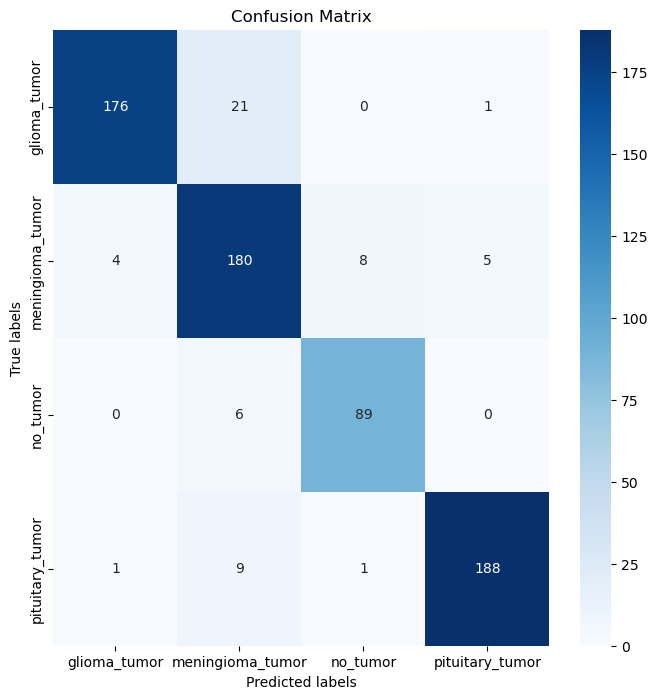


Classification Report:
Classification Report
                  precision    recall  f1-score   support

    glioma_tumor       0.97      0.89      0.93       198
meningioma_tumor       0.83      0.91      0.87       197
        no_tumor       0.91      0.94      0.92        95
 pituitary_tumor       0.97      0.94      0.96       199

        accuracy                           0.92       689
       macro avg       0.92      0.92      0.92       689
    weighted avg       0.92      0.92      0.92       689



In [102]:
# Predict on validation data
y_val_pred = best_vgg16_model.predict(X_val)
y_val_pred_arg = y_val_pred.argmax(axis=1)  # Get the index of the highest probability for each sample

# Confusion matrix
def confusion_matrix(data_set, predictions, labels):
    cmatrix = cm(data_set, predictions)
    fig, ax = plt.subplots(figsize=(8, 8))
    sns.heatmap(cmatrix, annot=True, cmap='Blues', fmt='g', ax=ax)
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix')
    ax.xaxis.set_ticklabels(labels)
    ax.yaxis.set_ticklabels(labels)
    plt.show()

# Classification report
def classification_report(data_set, predictions, labels):
    print('Classification Report')
    print(cr(data_set, predictions, target_names=labels))

# Compute and print confusion matrix and classification report
print("\nConfusion Matrix:")
confusion_matrix(y_val, y_val_pred_arg, labels)

print("\nClassification Report:")
classification_report(y_val, y_val_pred_arg, labels)


# EfficientNet

## Model Definition and Compilation

In [105]:
# Parameters
IMG_SHAPE = (256, 256, 3)  # Adjust based on your dataset
num_classes = len(labels)  # Adjust based on the number of classes in your dataset

# Build the EfficientNetB1 model
effnet = EfficientNetB1(weights='imagenet', include_top=False, input_shape=IMG_SHAPE)

# Add custom layers on top of EfficientNetB1
effnet_model = effnet.output
effnet_model = GlobalAveragePooling2D()(effnet_model)
effnet_model = Dropout(0.5)(effnet_model)
effnet_model = Dense(num_classes, activation='softmax')(effnet_model)  # Adjust for the number of classes

# Define the final EfficientNet-based model
effnet_model = Model(inputs=effnet.input, outputs=effnet_model)

# Compile the model
effnet_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Print model summary
effnet_model.summary()


Model: "functional_30"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)    │ (None, 256, 256, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ rescaling_2 (Rescaling)       │ (None, 256, 256, 3)       │               0 │ input_layer_4[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ normalization_1               │ (None, 256, 256, 3)       │               7 │ rescaling_2[0][0]          │
│ (Normalization)               │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ rescaling_3 (Rescaling)       │ (None, 256, 256, 3)       │               0 │ normalization_1[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stem_conv_pad (ZeroPadding2D) │ (None, 257, 257, 3)       │               0 │ rescaling_3[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stem_conv (Conv2D)            │ (None, 128, 128, 32)      │             864 │ stem_conv_pad[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stem_bn (BatchNormalization)  │ (None, 128, 128, 32)      │             128 │ stem_conv[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stem_activation (Activation)  │ (None, 128, 128, 32)      │               0 │ stem_bn[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_dwconv                │ (None, 128, 128, 32)      │             288 │ stem_activation[0][0]      │
│ (DepthwiseConv2D)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_bn                    │ (None, 128, 128, 32)      │             128 │ block1a_dwconv[0][0]       │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_activation            │ (None, 128, 128, 32)      │               0 │ block1a_bn[0][0]           │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_se_squeeze            │ (None, 32)                │               0 │ block1a_activation[0][0]   │
│ (GlobalAveragePooling2D)      │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_se_reshape (Reshape)  │ (None, 1, 1, 32)          │               0 │ block1a_se_squeeze[0][0]   │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_se_reduce (Conv2D)    │ (None, 1, 1, 8)           │             264 │ block1a_se_reshape[0][0]   │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_se_expand (Conv2D)    │ (None, 1, 1, 32)          │             28

 Total params: 6,580,363 (25.10 MB)

 Trainable params: 6,518,308 (24.87 MB)

 Non-trainable params: 62,055 (242.41 KB)

## TensorBoard and ModelCheckpoint Setup

In [107]:
# Define model path and create the directory if it doesn't exist
models_path = "models"  # Directory to save the model
if not os.path.exists(models_path):
    os.makedirs(models_path)

# TensorBoard and ModelCheckpoint setup
log_dir = "logs/fit/" + time.strftime("run_%Y%m%d-%H%M%S")
tensorboard = TensorBoard(log_dir=log_dir, histogram_freq=1)
checkpoint_filepath = f'{models_path}/best_effnet_model.keras'
checkpoint = ModelCheckpoint(filepath=checkpoint_filepath, save_best_only=True, monitor='val_loss', mode='min')


## Model Training

In [109]:
# Train the model
start_time = time.time()
history = effnet_model.fit(
    x=X_train, 
    y=y_train, 
    batch_size=32, 
    epochs=10, 
    validation_data=(X_val, y_val), 
    callbacks=[tensorboard, checkpoint]
)
end_time = time.time()
execution_time = end_time - start_time

# Function to display the execution time in hours, minutes, and seconds
def hms_string(sec_elapsed):
    h = int(sec_elapsed // 3600)
    m = int((sec_elapsed % 3600) // 60)
    s = int(sec_elapsed % 60)
    return f"{h}h:{m}m:{s}s"

print(f"Elapsed time: {hms_string(execution_time)}")


Epoch 1/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 401s 5s/step - accuracy: 0.7276 - loss: 0.6708 - val_accuracy: 0.8200 - val_loss: 0.5783
Epoch 2/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 217s 4s/step - accuracy: 0.9309 - loss: 0.2027 - val_accuracy: 0.8592 - val_loss: 0.4127
Epoch 3/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 215s 4s/step - accuracy: 0.9591 - loss: 0.1080 - val_accuracy: 0.9100 - val_loss: 0.3350
Epoch 4/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 212s 4s/step - accuracy: 0.9805 - loss: 0.0591 - val_accuracy: 0.5718 - val_loss: 2.0066
Epoch 5/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 209s 4s/step - accuracy: 0.9789 - loss: 0.0802 - val_accuracy: 0.6662 - val_loss: 1.7113
Epoch 6/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 209s 4s/step - accuracy: 0.9859 - loss: 0.0482 - val_accuracy: 0.6952 - val_loss: 1.0389
Epoch 7/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 208s 4s/step - accuracy: 0.9801 - loss: 0.0610 - val_accuracy: 0.8534 - val_loss: 0.4566
Epoch 8/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 189s 4s/step - accuracy: 0.9870 - loss: 0.0419 - val_accuracy: 0.9318 - v

## Plot Training/Validation Metrics

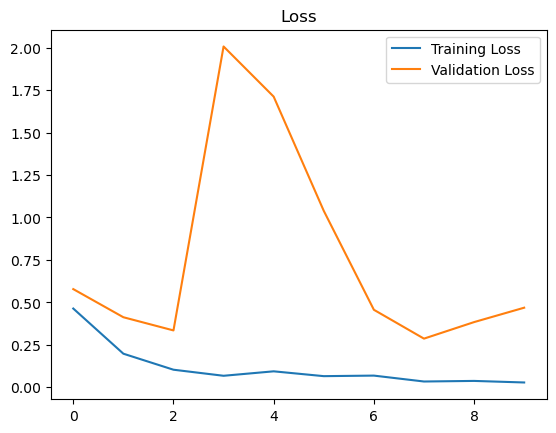

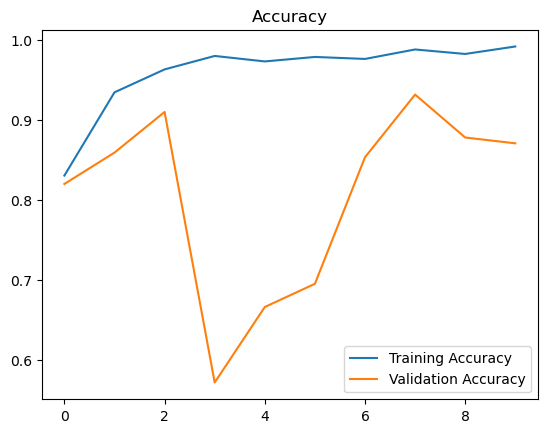

In [111]:
# Plot the training/validation metrics
plot_metrics(history)

## Evaluate the EfficientNet Model

In [113]:
# Load the best EfficientNet model
best_effnet_model = tf.keras.models.load_model(filepath=f'{models_path}/best_effnet_model.keras')

# Evaluate both the current and best models
print("Evaluating EfficientNet model:")
effnet_model.evaluate(x=X_val, y=y_val)

print("\nEvaluating best EfficientNet model:")
best_effnet_model.evaluate(x=X_val, y=y_val)

# Predict on validation data
y_val_pred = best_effnet_model.predict(X_val)
y_val_pred_arg = y_val_pred.argmax(axis=1)  # Get the index of the highest probability for each sample


Evaluating EfficientNet model:
22/22 ━━━━━━━━━━━━━━━━━━━━ 16s 732ms/step - accuracy: 0.8473 - loss: 0.5217

Evaluating best EfficientNet model:
22/22 ━━━━━━━━━━━━━━━━━━━━ 28s 726ms/step - accuracy: 0.3008 - loss: 676.9222
22/22 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step 


## Confusion Matrix and Classification Report


Confusion Matrix:


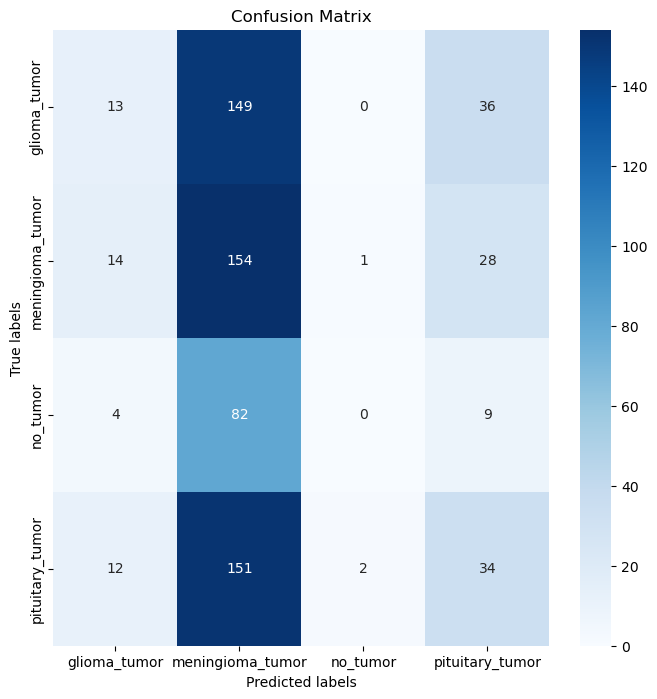

In [115]:
# Compute and print confusion matrix and classification report
print("\nConfusion Matrix:")
confusion_matrix(y_val, y_val_pred_arg, labels)

In [116]:
print("\nClassification Report:")
classification_report(y_val, y_val_pred_arg, labels)


Classification Report:
Classification Report
                  precision    recall  f1-score   support

    glioma_tumor       0.30      0.07      0.11       198
meningioma_tumor       0.29      0.78      0.42       197
        no_tumor       0.00      0.00      0.00        95
 pituitary_tumor       0.32      0.17      0.22       199

        accuracy                           0.29       689
       macro avg       0.23      0.25      0.19       689
    weighted avg       0.26      0.29      0.22       689



# Best model

From the results above, we could see that VGG16 has the highest accuracy of 92% so now we will tune it further for improvement in the accuracy and test it out on the testing dataset.

## Hyperparameter Tuning of VGG16

In [132]:
# HyperModel class for VGG16
class VGG16HyperModel(HyperModel):
    
    def __init__(self, input_shape, num_classes):
        self.input_shape = input_shape
        self.num_classes = num_classes
    
    def build(self, hp):
        # Build VGG16 model with imagenet weights
        vgg = VGG16(weights='imagenet', include_top=False, input_shape=self.input_shape)
        
        # Freeze the base model layers
        for layer in vgg.layers:
            layer.trainable = False
        
        # Add custom layers on top of VGG16 with hyperparameter tuning
        model = vgg.output
        model = Flatten()(model)
        model = Dense(512, activation='relu')(model)
        model = BatchNormalization()(model)
        model = Dropout(hp.Float('dropout', 0.3, 0.7, step=0.1))(model)  # Tune dropout between 0.3 and 0.7
        model = Dense(self.num_classes, activation='softmax')(model)
        
        model = Model(inputs=vgg.input, outputs=model)

        # Compile the model with hyperparameter tuning for optimizer and learning rate
        model.compile(
            optimizer=tf.keras.optimizers.Adam(hp.Choice('learning_rate', [1e-4, 1e-3, 1e-2])),  # Tune learning rate
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy']
        )
        
        return model

# Define the hypermodel for VGG16
hypermodel_vgg = VGG16HyperModel(input_shape=IMG_SHAPE, num_classes=num_classes)

# Define the tuner with Random Search for VGG16
tuner_vgg = RandomSearch(
    hypermodel_vgg,
    objective='val_loss',
    max_trials=5,  # Number of different hyperparameter combinations to try
    executions_per_trial=1,  # Number of models to build and fit for each trial
    directory='hyperparameter_tuning_vgg',  # Directory to save tuning results
    project_name='VGG16_tuning'
)

# Run the tuner search (remove callbacks during hyperparameter tuning)
tuner_vgg.search(X_train, y_train, epochs=10, validation_data=(X_val, y_val))

# Get the best hyperparameters
best_hps_vgg = tuner_vgg.get_best_hyperparameters(num_trials=1)[0]
print(f"Best learning rate: {best_hps_vgg.get('learning_rate')}")
print(f"Best dropout rate: {best_hps_vgg.get('dropout')}")

# Build and train the best model with TensorBoard and Checkpoint callbacks after tuning
best_vgg_model = tuner_vgg.hypermodel.build(best_hps_vgg)
history = best_vgg_model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val), callbacks=[tensorboard, checkpoint])

Trial 5 Complete [00h 33m 58s]
val_loss: 0.30968907475471497

Best val_loss So Far: 0.28448277711868286
Total elapsed time: 03h 40m 24s
Best learning rate: 0.001
Best dropout rate: 0.3
Epoch 1/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 206s 4s/step - accuracy: 0.7226 - loss: 1.0686 - val_accuracy: 0.8723 - val_loss: 0.6079
Epoch 2/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 204s 4s/step - accuracy: 0.9551 - loss: 0.1241 - val_accuracy: 0.8882 - val_loss: 0.3662
Epoch 3/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 203s 4s/step - accuracy: 0.9894 - loss: 0.0502 - val_accuracy: 0.9028 - val_loss: 0.3184
Epoch 4/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 202s 4s/step - accuracy: 0.9905 - loss: 0.0296 - val_accuracy: 0.9100 - val_loss: 0.2995
Epoch 5/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 202s 4s/step - accuracy: 0.9988 - loss: 0.0158 - val_accuracy: 0.9129 - val_loss: 0.3051
Epoch 6/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 204s 4s/step - accuracy: 0.9955 - loss: 0.0125 - val_accuracy: 0.9144 - val_loss: 0.2964
Epoch 7/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 206s 4s/step - 

## Test Evaluation and Performance Table

In [134]:
from sklearn.metrics import f1_score
import numpy as np
import pandas as pd

# Evaluate the best tuned VGG16 model on the test set
loss_test, acc_test = best_vgg_model.evaluate(x=X_test, y=y_test)

# Print test loss and accuracy
print(f"Test Loss = {loss_test}")
print(f"Test Accuracy = {acc_test}")

# Predict the probabilities for the test set and convert them to class labels
y_test_prob = np.argmax(best_vgg_model.predict(X_test), axis=1)

# Compute the F1-score for the test set
def compute_f1_score(y_true, y_pred):
    # Convert predictions and true labels into integers (if they aren't already)
    return f1_score(y_true, y_pred, average='macro')

# Compute and print F1-score on the test set
f1_score_test = compute_f1_score(y_test, y_test_prob)
print(f"F1 score on Testing: {f1_score_test}")

18/18 ━━━━━━━━━━━━━━━━━━━━ 51s 3s/step - accuracy: 0.9153 - loss: 0.2923
Test Loss = 0.28344205021858215
Test Accuracy = 0.9201388955116272
18/18 ━━━━━━━━━━━━━━━━━━━━ 51s 3s/step
F1 score on Testing: 0.9174306892395157


In [135]:
# Create a performance table
performance_data = {
    "Test Accuracy": [acc_test],
    "Test F1-Score": [f1_score_test]
}

# Convert the dictionary to a DataFrame
performance_df = pd.DataFrame(performance_data)

# Display the performance table
performance_df

,Test Accuracy,Test F1-Score
0,0.920139,0.917431
